# Helper notebook for generating population samples with individuals in it
Get the 10% of the actual population as a representative sample

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from population_meta_data import Constants

In [3]:
#population class for generating population samples (individuals)
CONSTANTS = Constants.CONSTANTS
class PopulationSampleGenerator():
    def __init__(self, cast):
        self.cast = cast
        self.women_ratio = CONSTANTS['cast'][self.cast]['women_ratio']
        self.sample_size = CONSTANTS['cast'][self.cast]['sample_size']
        self.women_age_bins = CONSTANTS['cast'][self.cast]['women_age_bins']
        self.women_age_bin_prob = CONSTANTS['cast'][self.cast]['women_age_bin_prob']
        self.men_age_bins = CONSTANTS['cast'][self.cast]['men_age_bins']
        self.men_age_bin_prob = CONSTANTS['cast'][self.cast]['men_age_bin_prob']
        self.median_age = CONSTANTS['cast'][self.cast]['median_age']

    def simulateAge(self):
        #simulate women age first
        sample_size_women = int(round(self.sample_size * self.women_ratio, 0))
        probs = self.women_age_bin_prob / self.women_age_bin_prob.sum()
        bin_indices = np.random.choice(len(probs), size=sample_size_women, p=probs)
        women_samples = np.random.uniform(self.women_age_bins[bin_indices], self.women_age_bins[bin_indices + 1])

        #simulate men age
        sample_size_men = int(round(self.sample_size * (1-self.women_ratio), 0))
        probs = self.men_age_bin_prob / self.men_age_bin_prob.sum()
        bin_indices = np.random.choice(len(probs), size=sample_size_men, p=probs)
        men_samples = np.random.uniform(self.men_age_bins[bin_indices], self.men_age_bins[bin_indices + 1])

        df = pd.DataFrame({
            'idx': range(0, self.sample_size), 
            'age': np.concatenate(
                    [np.round(women_samples, 0).astype('int'),
                    np.round(men_samples, 0).astype('int')]
                    ), 
            'sex' :np.concatenate(
                    [np.zeros(int(round(self.sample_size * self.women_ratio, 0))).astype('int'),
                    np.ones(int(round(self.sample_size * (1-self.women_ratio)))).astype('int')]
                    )})
        
        return df

    def plotAge(self):
        df = self.simulateAge()
        # create plots for the age groups in cast 4
        men = df[df['sex'] == 1]['age']
        women = df[df['sex'] == 0]['age']
        df['age_group'] = pd.cut(df['age'], self.women_age_bins)

        age_pyramid = (
            df
            .groupby(['age_group', 'sex'])
            .size()
            .reset_index(name='count')
        )
        pyramid = age_pyramid.pivot(index='age_group', columns='sex', values='count').fillna(0)
        pyramid.columns = ['Women', 'Men']
        pyramid['Men'] = -pyramid['Men']
        pyramid = pyramid.iloc[::-1, ::-1]

        figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        ax1.hist(women, bins=20, alpha=0.6, label='Women', color='salmon')
        ax1.axvline(self.median_age, color='k', linestyle='dashed', linewidth=1)
        ax1.hist(men, bins=20, alpha=0.6, label='Men', color='steelblue')
        ax1.legend()

        sns.barplot(
            x='Women', y=pyramid.index, data=pyramid.reset_index(), color='salmon', label='Women', order = pyramid.index

        )
        sns.barplot(
            x='Men', y=pyramid.index, data=pyramid.reset_index(), color='steelblue', label='Men', order = pyramid.index
        )
        plt.tight_layout()
        plt.savefig(f'{self.cast}cast_age_and_sex_plot.png')

        

/var/folders/41/f2g8g_gx5mxdj1zjg_yp7_c40000gn/T/ipykernel_1068/626341857.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['age_group', 'sex'])


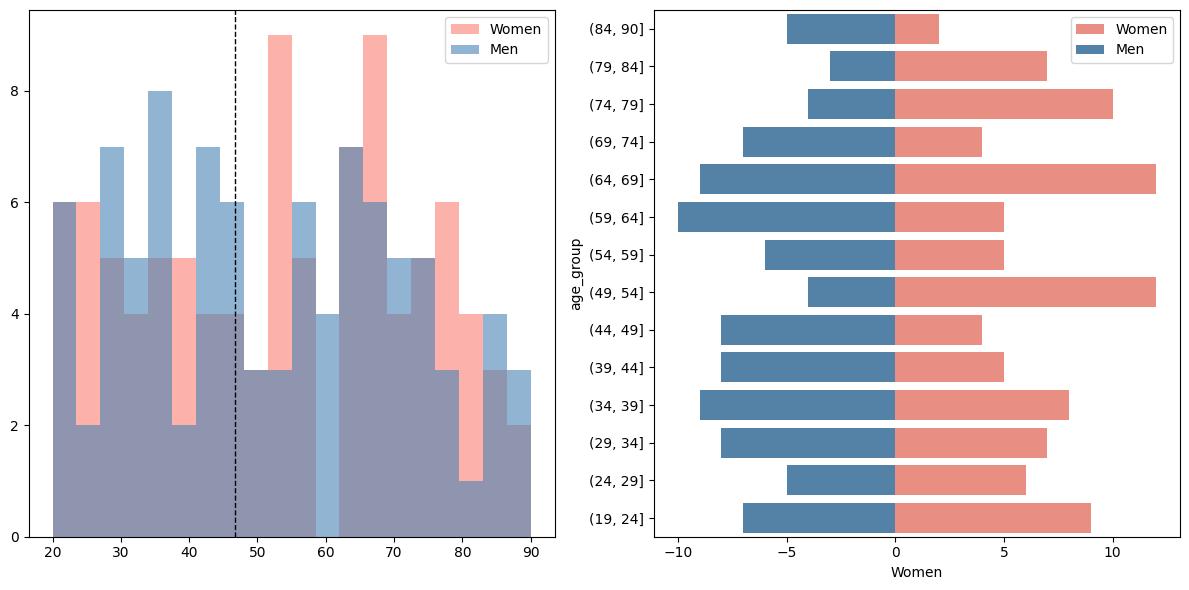

In [3]:
popsim = PopulationSampleGenerator("1st")
popsim.plotAge()

### Simulate yearly income

In [4]:
import numpy as np
import matplotlib.pyplot as plt

bins = np.array([0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 
                 50000, 60000, 70000, 100000, 125000])
probability_bins = np.array([0.02, 0.058, 0.076, 0.085, 0.1, 0.13, 0.071, 0.064,
                             0.054, 0.045, 0.069, 0.048, 0.06, 0.04])

# Compute the bin centers for plotting
bin_centers = 0.5 * (bins[:-1] + bins[1:])


mean = np.sum(probability_bins * bin_centers)
std = np.sqrt(np.sum(probability_bins * (bin_centers - mean)**2))
print(mean, std)

bin_centers_safe = np.where(bin_centers == 0, 1, bin_centers)
log_centers = np.log(bin_centers_safe)

mean_log = np.sum(probability_bins * log_centers)
std_log = np.sqrt(np.sum(probability_bins * (log_centers - mean_log)**2))
print(mean_log, std_log)
#log mean and log std for lognorm income distribution is 9.45 and 1.07 respectively


34402.5 25047.03941087649
9.455448916009015 1.0756001862584008


In [6]:
def sampleIncome(mu, std, n):
    sample = np.random.lognormal(mu, std, n)
    return sample

print(sampleIncome(CONSTANTS['income']['mu'], CONSTANTS['income']['sigma'], 1000))


[ 11843.34568216  20701.9289144    9033.84978048   2853.02621893
   9356.7428804   16966.38488872  45467.5117358   27692.78915276
  19512.25486946   5174.52726133   3538.9618872    7375.96750364
  11785.91680988  10870.20444879   5483.41063874  15041.11780714
   6159.4419741   14970.59287312  14575.93560085  43338.60259008
    795.73884635  35719.56331772   1974.7340254    5481.4947637
   1923.44719291  16454.79022697   5329.26949076  19445.11511957
  23196.71011613   3391.73921362   3589.4217865   28181.05629733
   6321.34939148  12666.1915341    5183.2054943    3120.07844844
  27543.9350275    8139.52114177  19545.90370878  73030.27889119
  34475.10944528   9214.53567729  15620.45795737  18918.37378981
  19616.39570495  26700.15613971  30954.05078355  59255.23274259
  14266.04171267  22876.63287185   5972.25682623   3952.08111079
   4788.43758286   6686.11984281  12701.23186522 113517.96238648
  13125.53112979  16218.17448616   4969.66381749  39496.40940204
   6492.5886333    6660.02

In [2]:
const = Constants.CONSTANTS
const.keys()

dict_keys(['cast', 'income'])